In [1]:
import requests

import kagglehub
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.naive_bayes import GaussianNB
from umap import UMAP
import matplotlib.pyplot as plt
from tqdm import tqdm

import xgboost as xgb

c:\Users\48518\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Input and basic preprocessing

In [ ]:
#path = kagglehub.dataset_download("maharshipandya/-spotify-tracks-dataset")

In [2]:
#df_full = pd.read_csv(path + "\\Dataset.csv", index_col=0).drop_duplicates(subset=['track_name', 'artists'])

df_full = pd.read_csv("dataset.csv", index_col=0).drop_duplicates(subset=['track_name', 'artists'])

df_full.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,release_date,release_year
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,...,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,2022-04-08,2022
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,...,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,2021-04-30,2021
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,...,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,2021-03-17,2021
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,...,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,2018-08-10,2018
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,...,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,2017-02-03,2017


In [ ]:
#Add release date to dataset

'''release_dates = []
tracks = []
TOKEN = ""
header = {"Authorization" : f"Bearer  {TOKEN}"}
for id in tqdm(df_full['track_id']):
    if len(tracks) < 50:
        tracks.append(id)
        continue
    tracks.append(id)
    resp = requests.get(f"https://api.spotify.com/v1/tracks?ids={','.join(tracks)}", headers=header)
    for x in resp.json()['tracks']:
        release_dates.append(x['album']['release_date'])
    tracks = []

resp = requests.get(f"https://api.spotify.com/v1/tracks?ids={','.join(tracks)}", headers=header)
for x in resp.json()['tracks']:
    release_dates.append(x['album']['release_date'])

df_full['release_date'] = release_dates
df_full.to_csv('dataset.csv', index=True)'''


In [3]:
df_full.dtypes

track_id             object
artists              object
album_name           object
track_name           object
popularity            int64
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
release_date         object
release_year          int64
dtype: object

In [4]:
#We can ignore theese missing values, we will not use theese variables for classification anyway
df_full.isnull().sum()

track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
release_date        0
release_year        0
dtype: int64

In [5]:
#This variable is very noisy, and mostly incorrect
df_full = df_full.drop(columns=['time_signature']);

In [6]:
df_full['release_year'] = df_full['release_date'].str[:4].astype('int64')

In [7]:
df_full.loc[:, ['release_year', 'track_id']].groupby('release_year').count().sort_values('release_year')

,track_id
release_year,
0,158
1905,2
1913,1
1923,1
1925,7
...,...
2021,7501
2022,14482
2023,73


In [8]:
#We drop dataset columns where year value is missing
df_full = df_full.loc[df_full['release_year'] != 0]

# The loudness war
The loudness war is, according to Wikipedia "trend of increasing audio levels in recorded music, which reduces audio fidelity and—according to many critics—listener enjoyment". According to many it was mainly visible in the late 90s, and early 00s. We can verify the existance of such phenomenon on our data. The plot shows the mean loudness of tracks across the years smoothed out by rolling window mean method

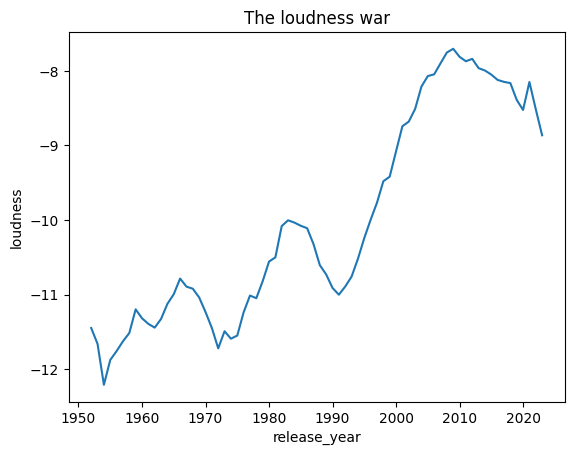

In [36]:
sns.lineplot(df_full.loc[df_full['release_year'] >= 1950].groupby('release_year')['loudness'].mean().rolling(window=5, center=True).mean().reset_index(), 
             x='release_year', 
             y='loudness',
             ).set_title("The loudness war");

# EDA

In [9]:
df_full.loc[:, 'track_genre'].unique()

array(['acoustic', 'afrobeat', 'alt-rock', 'alternative', 'ambient',
       'anime', 'black-metal', 'bluegrass', 'blues', 'brazil',
       'breakbeat', 'british', 'cantopop', 'chicago-house', 'children',
       'chill', 'classical', 'club', 'comedy', 'country', 'dance',
       'dancehall', 'death-metal', 'deep-house', 'detroit-techno',
       'disco', 'disney', 'drum-and-bass', 'dub', 'dubstep', 'edm',
       'electro', 'electronic', 'emo', 'folk', 'forro', 'french', 'funk',
       'garage', 'german', 'gospel', 'goth', 'grindcore', 'groove',
       'grunge', 'guitar', 'happy', 'hard-rock', 'hardcore', 'hardstyle',
       'heavy-metal', 'hip-hop', 'honky-tonk', 'house', 'idm', 'indian',
       'indie-pop', 'indie', 'industrial', 'iranian', 'j-dance', 'j-idol',
       'j-pop', 'j-rock', 'jazz', 'k-pop', 'kids', 'latin', 'latino',
       'malay', 'mandopop', 'metal', 'metalcore', 'minimal-techno', 'mpb',
       'new-age', 'opera', 'pagode', 'party', 'piano', 'pop-film', 'pop',
       'pow

In [10]:
#Let's take only some of subgenres for EDA. It would be hard to make graph for 130 genres

genres_subset = ['singer-songwriter', 'death-metal', 'hard-rock', 'blues', 'hip-hop', 'country', 'folk', 'black-metal', 'rock', 'alternative', 'pop', 'psych-rock']
df_full = df_full.loc[lambda df: df['track_genre'].isin(genres_subset)].reset_index(drop=True)
NUM_OF_CLASSES = len(genres_subset)

In [11]:
df_full.loc[:, ['track_genre', 'track_id']].groupby('track_genre').count().sort_values('track_id')

,track_id
track_genre,
rock,167
alternative,238
pop,289
singer-songwriter,430
psych-rock,550
country,570
hard-rock,626
hip-hop,645
blues,686


In [12]:
df_full.loc[:, ['track_genre', 'acousticness']].groupby('track_genre').mean().sort_values('acousticness', ascending=False)

,acousticness
track_genre,
singer-songwriter,0.571864
folk,0.484270
pop,0.382901
psych-rock,0.342094
blues,0.327319
country,0.299410
hip-hop,0.222678
rock,0.211643
alternative,0.181499


In [ ]:
df = df_full.drop(['track_id', 'artists', 'album_name', 'release_date', 'track_name'], axis=1)

In [44]:
label_encoder=LabelEncoder()

In [45]:
df['track_genre']=label_encoder.fit_transform(df['track_genre'])

df.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_genre,release_year
0,79,204763,True,0.870,0.523,1,-8.052,0,0.0602,0.43300,0.000021,0.1130,0.319,110.020,0,2021
1,86,168601,True,0.695,0.540,4,-5.692,1,0.0493,0.29900,0.000000,0.3670,0.415,121.932,0,2021
2,81,162680,True,0.773,0.470,2,-7.930,1,0.0299,0.01530,0.000193,0.0851,0.399,94.995,0,2020
3,85,216880,False,0.556,0.864,3,-5.870,0,0.0584,0.00958,0.000000,0.2090,0.400,105.143,0,2000
4,83,185586,False,0.496,0.863,9,-4.153,1,0.0381,0.00460,0.000000,0.6390,0.243,110.018,0,2003


In [46]:
df_num = df.drop(columns=['track_genre'])

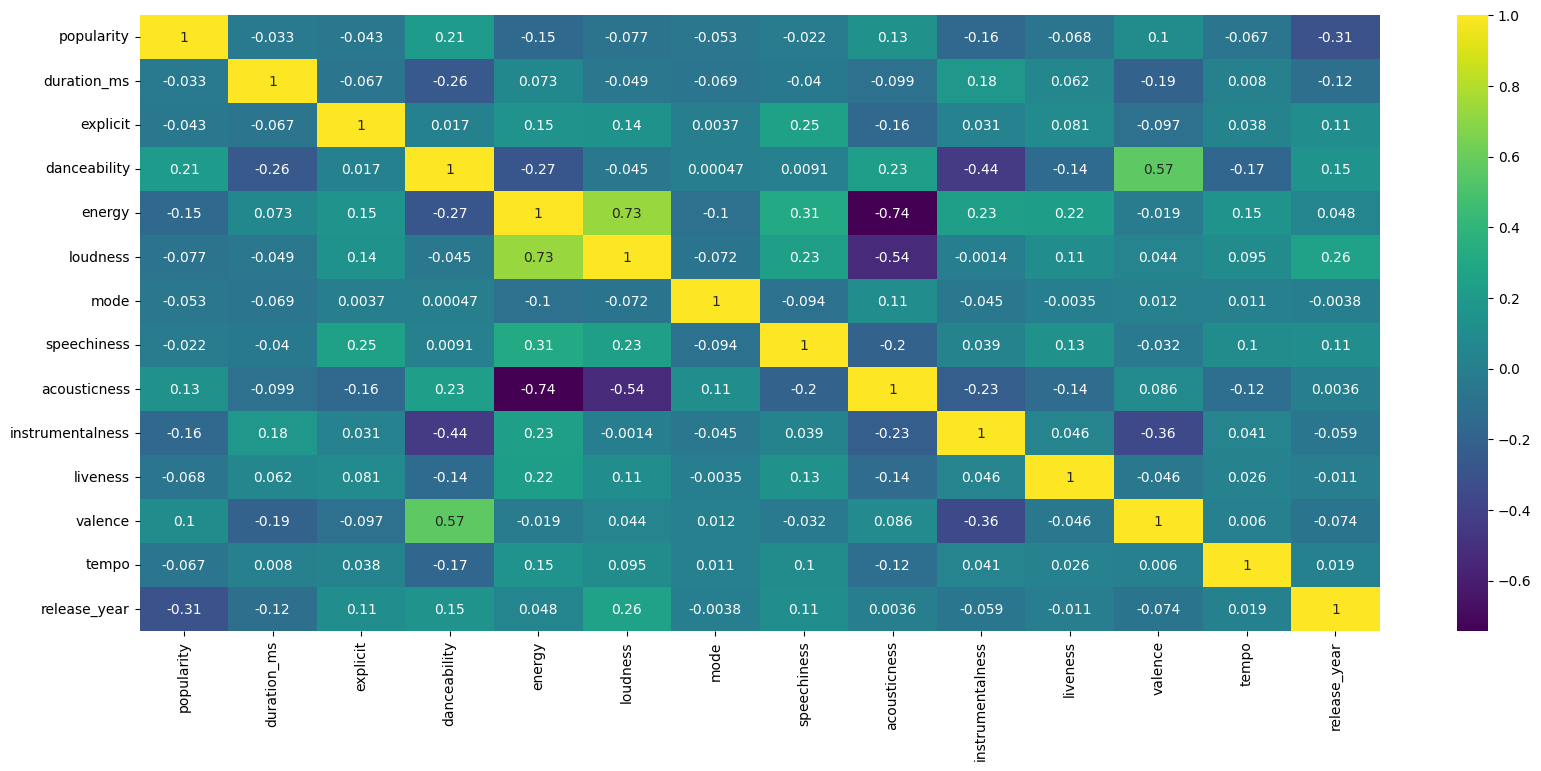

In [30]:
cor=df_num.corr()
plt.figure(figsize=(20,8))
sns.heatmap(cor, annot=True, cmap='viridis')
plt.show()

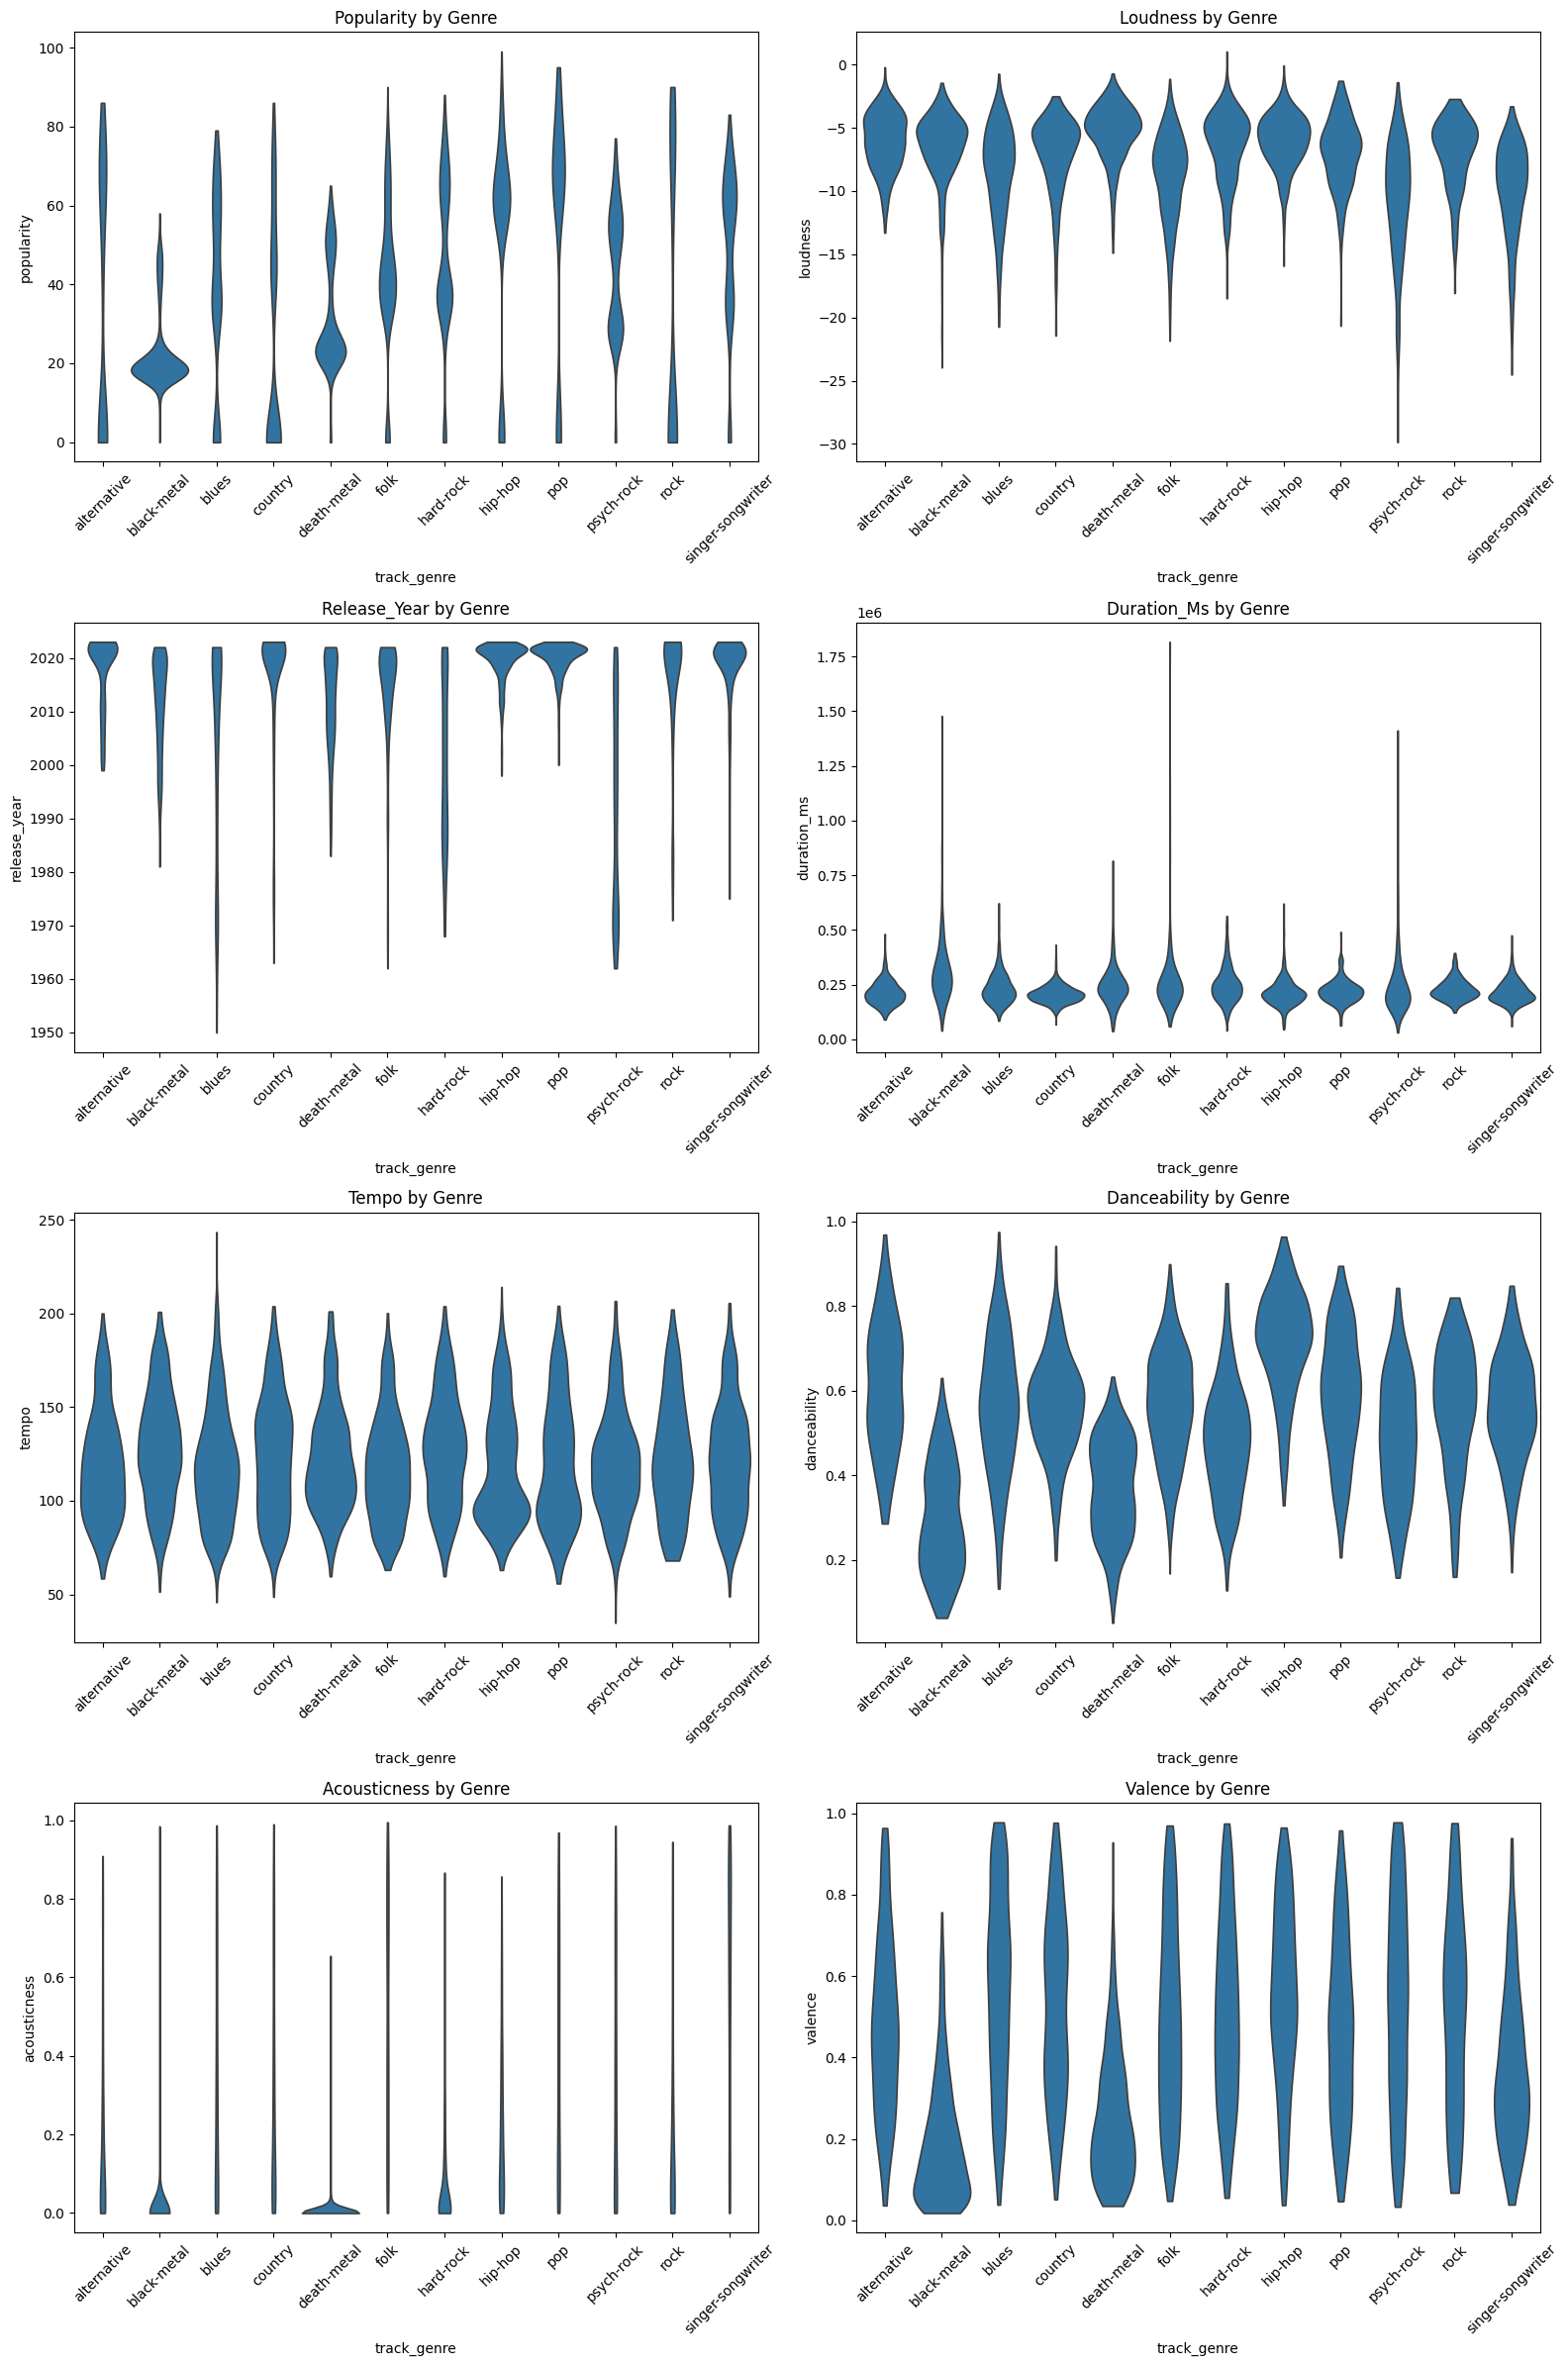

In [31]:
features = ['popularity', 'loudness', 'release_year', 'duration_ms', 'tempo', 'danceability', 'acousticness', 'valence']

# Create subplots
fig, axes = plt.subplots(nrows=int(len(features) / 2), ncols=2, figsize=(16, 24))

axes = axes.flatten()

for i, feature in enumerate(features):
    sns.violinplot(df_full, x='track_genre', y=feature, inner=None, cut=0, width=1, ax=axes[i])
    axes[i].set_title(f'{feature.title()} by Genre')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [121]:
pd.DataFrame(df_full.loc[df_full.groupby('track_genre').idxmax().loc[:, 'popularity'].tolist()].loc[:, ['artists', 'track_name', 'popularity', 'track_genre']])

,artists,track_name,popularity,track_genre
1,GAYLE,abcdefu,86,alternative
239,Make Them Suffer,Doomswitch,58,black-metal
1230,Cage The Elephant,Cigarette Daydreams,79,blues
2237,Morgan Wallen,You Proof,86,country
2492,Slayer,Raining Blood,65,death-metal
3376,Seafret,Atlantis,90,folk
4094,Ghost,Mary On A Cross,88,hard-rock
5199,Bizarrap;Quevedo,"Quevedo: Bzrp Music Sessions, Vol. 52",99,hip-hop
5381,Harry Styles,As It Was,95,pop
5654,Pink Floyd,Wish You Were Here,77,psych-rock


In [122]:
scaler = StandardScaler()
norm_df = df.copy()
norm_df.loc[:, ['popularity', 'tempo', 'loudness', 'duration_ms', 'release_year', 'key']] = scaler.fit_transform(df.loc[:, ['popularity', 'tempo', 'loudness', 'duration_ms', 'release_year', 'key']])

C:\Users\48518\AppData\Local\Temp\ipykernel_19404\1148918695.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.68744559 1.97783089 1.77041282 ... 0.15255186 0.15255186 0.89925692]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_df.loc[:, ['popularity', 'tempo', 'loudness', 'duration_ms', 'release_year', 'key']] = scaler.fit_transform(df.loc[:, ['popularity', 'tempo', 'loudness', 'duration_ms', 'release_year', 'key']])
C:\Users\48518\AppData\Local\Temp\ipykernel_19404\1148918695.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.37102632 -0.69309259 -0.74582624 ...  0.20423451 -0.41981452
 -0.61959857]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_df.loc[:, ['popularity', 'tempo', 'loudness', 'duration_ms', 'release_year', 'key']] = scaler.f

In [76]:
X_train, X_test, y_train, y_test = train_test_split(norm_df.drop(columns=['track_genre']), norm_df.loc[:, 'track_genre'], test_size=0.2, shuffle=True, random_state=42)

In [77]:
X_train

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,release_year
2488,0.816290,-0.200294,False,0.158,0.572,0.467220,0.315049,0,0.0346,0.000926,0.893000,0.1440,0.3470,-1.442919,-0.871707
4461,1.065191,0.080189,False,0.414,0.897,-0.096278,0.282605,0,0.0538,0.000402,0.000002,0.0809,0.2630,1.616377,-1.972389
6544,1.645962,-0.045567,False,0.527,0.942,-1.223273,0.502533,0,0.0366,0.011500,0.000000,0.1880,0.4950,0.876297,-1.834804
4771,1.314093,-0.762356,False,0.908,0.314,-1.505022,-0.638449,1,0.1160,0.042400,0.000041,0.0727,0.2440,-0.848167,0.710523
3135,-0.677120,-0.497049,False,0.454,0.987,0.748969,0.931190,1,0.1100,0.000006,0.663000,0.2840,0.0619,0.250898,0.160182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,0.650355,-0.174039,False,0.472,0.468,-0.096278,-0.038386,1,0.0281,0.166000,0.000161,0.1460,0.3860,0.385222,0.091390
5191,0.857773,-0.444120,False,0.655,0.629,-1.223273,0.045738,1,0.0415,0.001090,0.063000,0.0752,0.1930,0.317493,0.297768
5226,0.816290,0.191659,False,0.431,0.794,0.185471,0.462337,0,0.4280,0.075900,0.000000,0.8500,0.4480,-1.581245,0.366560
5390,1.397060,-0.088940,False,0.605,0.530,1.594216,0.299832,1,0.0246,0.821000,0.000000,0.1310,0.3970,-0.950244,0.572938


In [78]:
classifier = RandomForestClassifier(random_state=0)
classifier.fit(X_train, y_train);

In [79]:
y_predict = classifier.predict(X_test)

In [80]:
print('Random forest classifier performance:')
print(f'Accuracy score: {accuracy_score(y_test, y_predict)}')
print(f'F1 score: {f1_score(y_test, y_predict, average=None)}')

Random forest classifier performance:
Accuracy score: 0.6076414401175606
F1 score: [0.12307692 0.79318735 0.42145594 0.53811659 0.76426799 0.54711246
 0.62450593 0.71014493 0.37647059 0.59360731 0.05555556 0.52173913]


In [81]:
classifier = xgb.XGBClassifier(
    objective='multi:softprob',  
    num_class=NUM_OF_CLASSES,                 
    eval_metric='mlogloss',     
    use_label_encoder=False
)
classifier.fit(X_train, y_train);

c:\Users\48518\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:27:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [82]:
y_predict = classifier.predict(X_test)

In [83]:
print('XGB classifier performance:')
print(f'Accuracy score: {accuracy_score(y_test, y_predict)}')
print(f'F1 score: {f1_score(y_test, y_predict, average=None)}')

XGB classifier performance:
Accuracy score: 0.6171932402645114
F1 score: [0.28205128 0.81108312 0.48201439 0.51184834 0.79197995 0.50955414
 0.64541833 0.7265625  0.45098039 0.64864865 0.09302326 0.44444444]


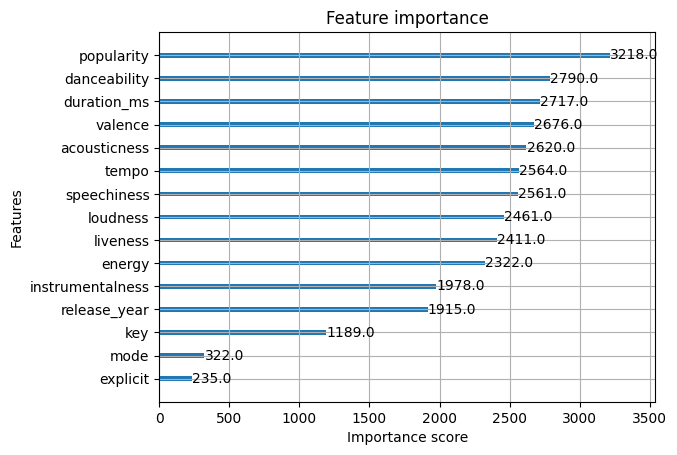

In [84]:
xgb.plot_importance(classifier);

In [85]:
classifier = GaussianNB()
classifier.fit(X_train, y_train);

In [86]:
y_predict = classifier.predict(X_test)

In [87]:
print('Naive Bayes classifier performance:')
print(f'Accuracy score: {accuracy_score(y_test, y_predict)}')
print(f'F1 score: {f1_score(y_test, y_predict, average=None)}')

Naive Bayes classifier performance:
Accuracy score: 0.4342395297575312
F1 score: [0.14814815 0.5775076  0.23115578 0.3974359  0.64166667 0.27983539
 0.44736842 0.50190114 0.23448276 0.39252336 0.         0.42268041]


## Feature engineering

In [ ]:
# Adding some random columns
new_df = norm_df.copy()
new_df['valence_per_ms'] = new_df['valence'] / new_df['duration_ms']
new_df['idk'] = new_df['tempo'] * new_df['danceability']
new_df.loc[:, ['valence_per_ms', 'idk']] = scaler.fit_transform(new_df.loc[:, ['valence_per_ms', 'idk']])

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

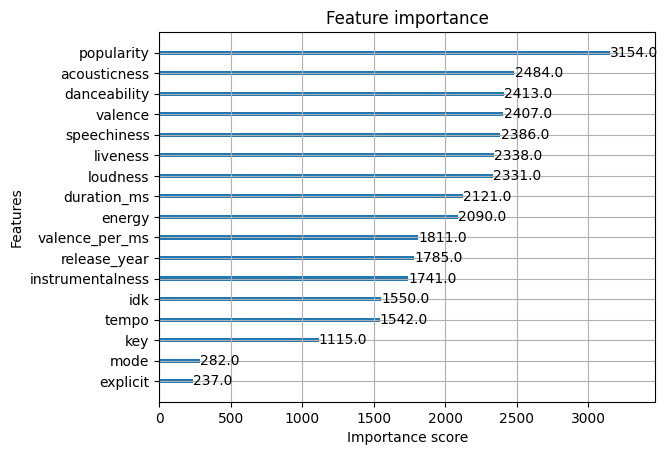

In [ ]:
# Fitting XGBoost to the new dataframe
classifier = xgb.XGBClassifier(
    objective='multi:softprob',  
    num_class=NUM_OF_CLASSES,                 
    eval_metric='mlogloss'
)
X_train, X_test, y_train, y_test = train_test_split(new_df.drop(columns=['track_genre']), norm_df.loc[:, 'track_genre'], test_size=0.2, shuffle=True, random_state=42)
classifier.fit(X_train, y_train)
xgb.plot_importance(classifier)

In [ ]:
# Comparison with the previous dataframe
print("Seed | Old acc | New acc")
total_diff = 0
for seed in [41, 42, 43, 44, 45, 46, 47, 48, 49, 50]:
    X_train, X_test, y_train, y_test = train_test_split(norm_df.drop(columns=['track_genre']), norm_df.loc[:, 'track_genre'], test_size=0.2, shuffle=True, random_state=seed)
    classifier.fit(X_train, y_train)
    y_predict = classifier.predict(X_test)
    acc1 = accuracy_score(y_test, y_predict)

    X_train, X_test, y_train, y_test = train_test_split(new_df.drop(columns=['track_genre']), norm_df.loc[:, 'track_genre'], test_size=0.2, shuffle=True, random_state=seed)
    classifier.fit(X_train, y_train)
    y_predict = classifier.predict(X_test)
    acc2 = accuracy_score(y_test, y_predict)

    total_diff += (acc2 - acc1)

    print(f" {seed}  | {f"{acc1:.5f}"} | {f"{acc2:.5f}"}")
print("Average Difference:", total_diff/10)

Seed | Old acc | New acc
 41  | 0.63850 | 0.62234
 42  | 0.61719 | 0.62013
 43  | 0.61719 | 0.61278
 44  | 0.63483 | 0.63336
 45  | 0.63336 | 0.64438
 46  | 0.62307 | 0.61499
 47  | 0.62895 | 0.62601
 48  | 0.63336 | 0.63189
 49  | 0.61425 | 0.61940
 50  | 0.64144 | 0.64879
Difference: -0.008082292432035065


In [ ]:
# Trying to find the best new columns to add
scores = {}
columns = norm_df.columns.drop(["track_genre", "explicit", "mode", "key", "tempo"])
for i, col1 in enumerate(columns):
    for j, col2 in enumerate(columns[i+1::]):
        print(col1, "*", col2)
        new_df = norm_df.copy()
        new_df["new"] = new_df[col1] * new_df[col2]
        new_df.loc[:, ['new']] = scaler.fit_transform(new_df.loc[:, ['new']])

        acc = 0
        for seed in [41, 42, 43]:
            X_train, X_test, y_train, y_test = train_test_split(new_df.drop(columns=['track_genre']), norm_df.loc[:, 'track_genre'], test_size=0.2, shuffle=True, random_state=seed)
            classifier.fit(X_train, y_train)
            y_predict = classifier.predict(X_test)
            acc2 = accuracy_score(y_test, y_predict)

            acc += acc2
        scores[(col1, col2)] = acc/3

popularity * duration_ms
popularity * danceability
popularity * energy
popularity * loudness
popularity * speechiness
popularity * acousticness
popularity * instrumentalness
popularity * liveness
popularity * valence
popularity * release_year
duration_ms * danceability
duration_ms * energy
duration_ms * loudness
duration_ms * speechiness
duration_ms * acousticness
duration_ms * instrumentalness
duration_ms * liveness
duration_ms * valence
duration_ms * release_year
danceability * energy
danceability * loudness
danceability * speechiness
danceability * acousticness
danceability * instrumentalness
danceability * liveness
danceability * valence
danceability * release_year
energy * loudness
energy * speechiness
energy * acousticness
energy * instrumentalness
energy * liveness
energy * valence
energy * release_year
loudness * speechiness
loudness * acousticness
loudness * instrumentalness
loudness * liveness
loudness * valence
loudness * release_year
speechiness * acousticness
speechiness *

In [ ]:
print(sorted(scores.items(), key = lambda x : -x[1])[:5:])

[(('danceability', 'speechiness'), 0.6235611070291452), (('loudness', 'release_year'), 0.6230712711241734), (('duration_ms', 'instrumentalness'), 0.6228263531716874), (('acousticness', 'valence'), 0.6228263531716874), (('popularity', 'loudness'), 0.6223365172667157)]


In [ ]:
# We choose 10 new columns with the highest accuracy
new_cols = sorted(scores.keys(), key = lambda x : -scores[x])[:10:]
new_df = norm_df.copy()
for x1, x2 in new_cols:
    new_df[f"{x1}*{x2}"] = new_df[x1] * new_df[x2]
    new_df.loc[:, [f"{x1}*{x2}"]] = scaler.fit_transform(new_df.loc[:, [f"{x1}*{x2}"]])


In [192]:
# classifier = RandomForestClassifier()
classifier = xgb.XGBClassifier(
    objective='multi:softprob',  
    num_class=NUM_OF_CLASSES,                 
    eval_metric='mlogloss'
)

Seed | Old acc | New acc
 41  | 0.63850 | 0.64217
 42  | 0.61719 | 0.60544
 43  | 0.61719 | 0.63336
 44  | 0.63483 | 0.64585
 45  | 0.63336 | 0.63409
 46  | 0.62307 | 0.62381
 47  | 0.62895 | 0.63777
 48  | 0.63336 | 0.64144
 49  | 0.61425 | 0.62748
 50  | 0.64144 | 0.65246
Average Difference: 0.006171932402645119


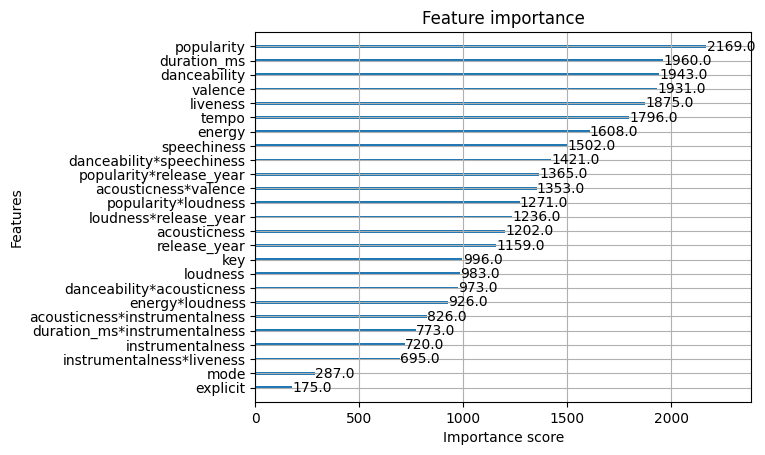

In [ ]:
# Testing the new dataframe
print("Seed | Old acc | New acc")
total_diff = 0
for seed in [41, 42, 43, 44, 45, 46, 47, 48, 49, 50]:
    X_train, X_test, y_train, y_test = train_test_split(norm_df.drop(columns=['track_genre']), norm_df.loc[:, 'track_genre'], test_size=0.2, shuffle=True, random_state=seed)
    classifier.fit(X_train, y_train)
    y_predict = classifier.predict(X_test)
    acc1 = accuracy_score(y_test, y_predict)

    X_train, X_test, y_train, y_test = train_test_split(new_df.drop(columns=['track_genre']), norm_df.loc[:, 'track_genre'], test_size=0.2, shuffle=True, random_state=seed)
    classifier.fit(X_train, y_train)
    y_predict = classifier.predict(X_test)
    acc2 = accuracy_score(y_test, y_predict)

    total_diff += (acc2 - acc1)

    print(f" {seed}  | {f"{acc1:.5f}"} | {f"{acc2:.5f}"}")
    if seed == 49:
        xgb.plot_importance(classifier)
print("Average Difference:", total_diff/10)